# 2022100814 정영훈 flowers 인공지능 과제

### 필요한 라이브러리 가져오기

In [1]:
!sudo apt-get install -y fonts-nanum*
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
fonts-nanum is already the newest version (20200506-1).
fonts-nanum-coding is already the newest version (2.5-3).
fonts-nanum-eco is already the newest version (1.000-7).
fonts-nanum-extra is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts,

In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import keras
import sklearn as sk
import matplotlib.pyplot as plt
from matplotlib import rc
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import cv2



In [3]:
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

### 데이터 로드 및 전처리

In [4]:
# 이미지를 정규화하는 함수
def normalize_image(image_path, target_size=(128, 128)):
    """이미지 경로를 받아서 정규화하고 리사이즈한 이미지를 반환"""
    image = Image.open(image_path)
    image = image.resize(target_size)  # 이미지 크기 조정 (필요시)
    image_array = np.array(image) / 255.0  # 정규화 (0~1 범위로 변환)
    return image_array

def load_images_from_directory(directory_path, target_size=(128, 128)):
    """디렉토리 내 이미지들을 정규화하고 리스트로 반환"""
    image_list = []
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        if file_path.endswith((".jpg", ".jpeg", ".png")):
            image = normalize_image(file_path, target_size)
            image_list.append(image)
    return image_list

# 데이터셋 경로 설정
data_train = '/content/drive/MyDrive/flowers/train'
test_folder = '/content/drive/MyDrive/flowers/test'

# 꽃 이름별로 이미지 리스트를 저장할 딕셔너리
flowers = {}  # 꽃 이름에 따라 이미지가 저장될 딕셔너리

# 테스트 데이터를 정규화된 이미지로 처리
X_test = []  # 테스트 데이터를 담을 리스트
y_test = []  # 테스트 레이블을 담을 리스트 (레이블이 없으면 사용 안 함)

# 학습 데이터를 꽃 이름별로 정규화된 이미지 목록으로 저장
for dirname, _, filenames in os.walk(data_train):
    flower_name = dirname.split('/')[-1]  # 폴더 이름을 꽃 이름으로 사용
    if dirname != data_train:  # 최상위 폴더는 제외
        print(f"Number of {flower_name} images: {len(filenames)}")
        flower_images = load_images_from_directory(dirname)  # 꽃 이름별 이미지 리스트 반환
        flowers[flower_name] = flower_images  # 꽃 이름과 이미지 리스트 저장

# 학습 데이터를 꽃 이름별로 정규화된 이미지와 레이블로 나누어 저장
X_train = []
y_train = []

for flower_name, image_list in flowers.items():
    for image in image_list:
        X_train.append(image)  # 이미지를 X에 추가
        y_train.append(flower_name)  # 꽃 이름을 y에 추가

# X_train과 y_train을 numpy 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

# 테스트 데이터 경로에서 이미지를 읽어서 정규화
for filename in os.listdir(test_folder):
    file_path = os.path.join(test_folder, filename)
    if file_path.endswith(".jpg") or file_path.endswith(".jpeg") or file_path.endswith(".png"):
        img = Image.open(file_path)  # 이미지 열기
        img = img.resize((128, 128))  # 이미지 크기 조정
        img = np.array(img) / 255.0  # 정규화
        X_test.append(img)  # 테스트 이미지에 추가
        # 레이블이 없기 때문에 y_test는 추가하지 않습니다

X_test = np.array(X_test)

# 결과 확인
print(f"Total training flowers categories: {len(flowers)}")
print(f"Training images: {len(X_train)}")
print(f"Test images: {len(X_test)}")

Number of dandelion images: 646
Number of daisy images: 501
Number of rose images: 497
Number of tulip images: 607
Number of sunflower images: 495
Total training flowers categories: 5
Training images: 2746
Test images: 924


In [5]:
print(X_train.dtype)  # X_train의 데이터 타입 확인
print(X_test.dtype)   # X_test의 데이터 타입 확인

float64
float64


## 데이터 확인

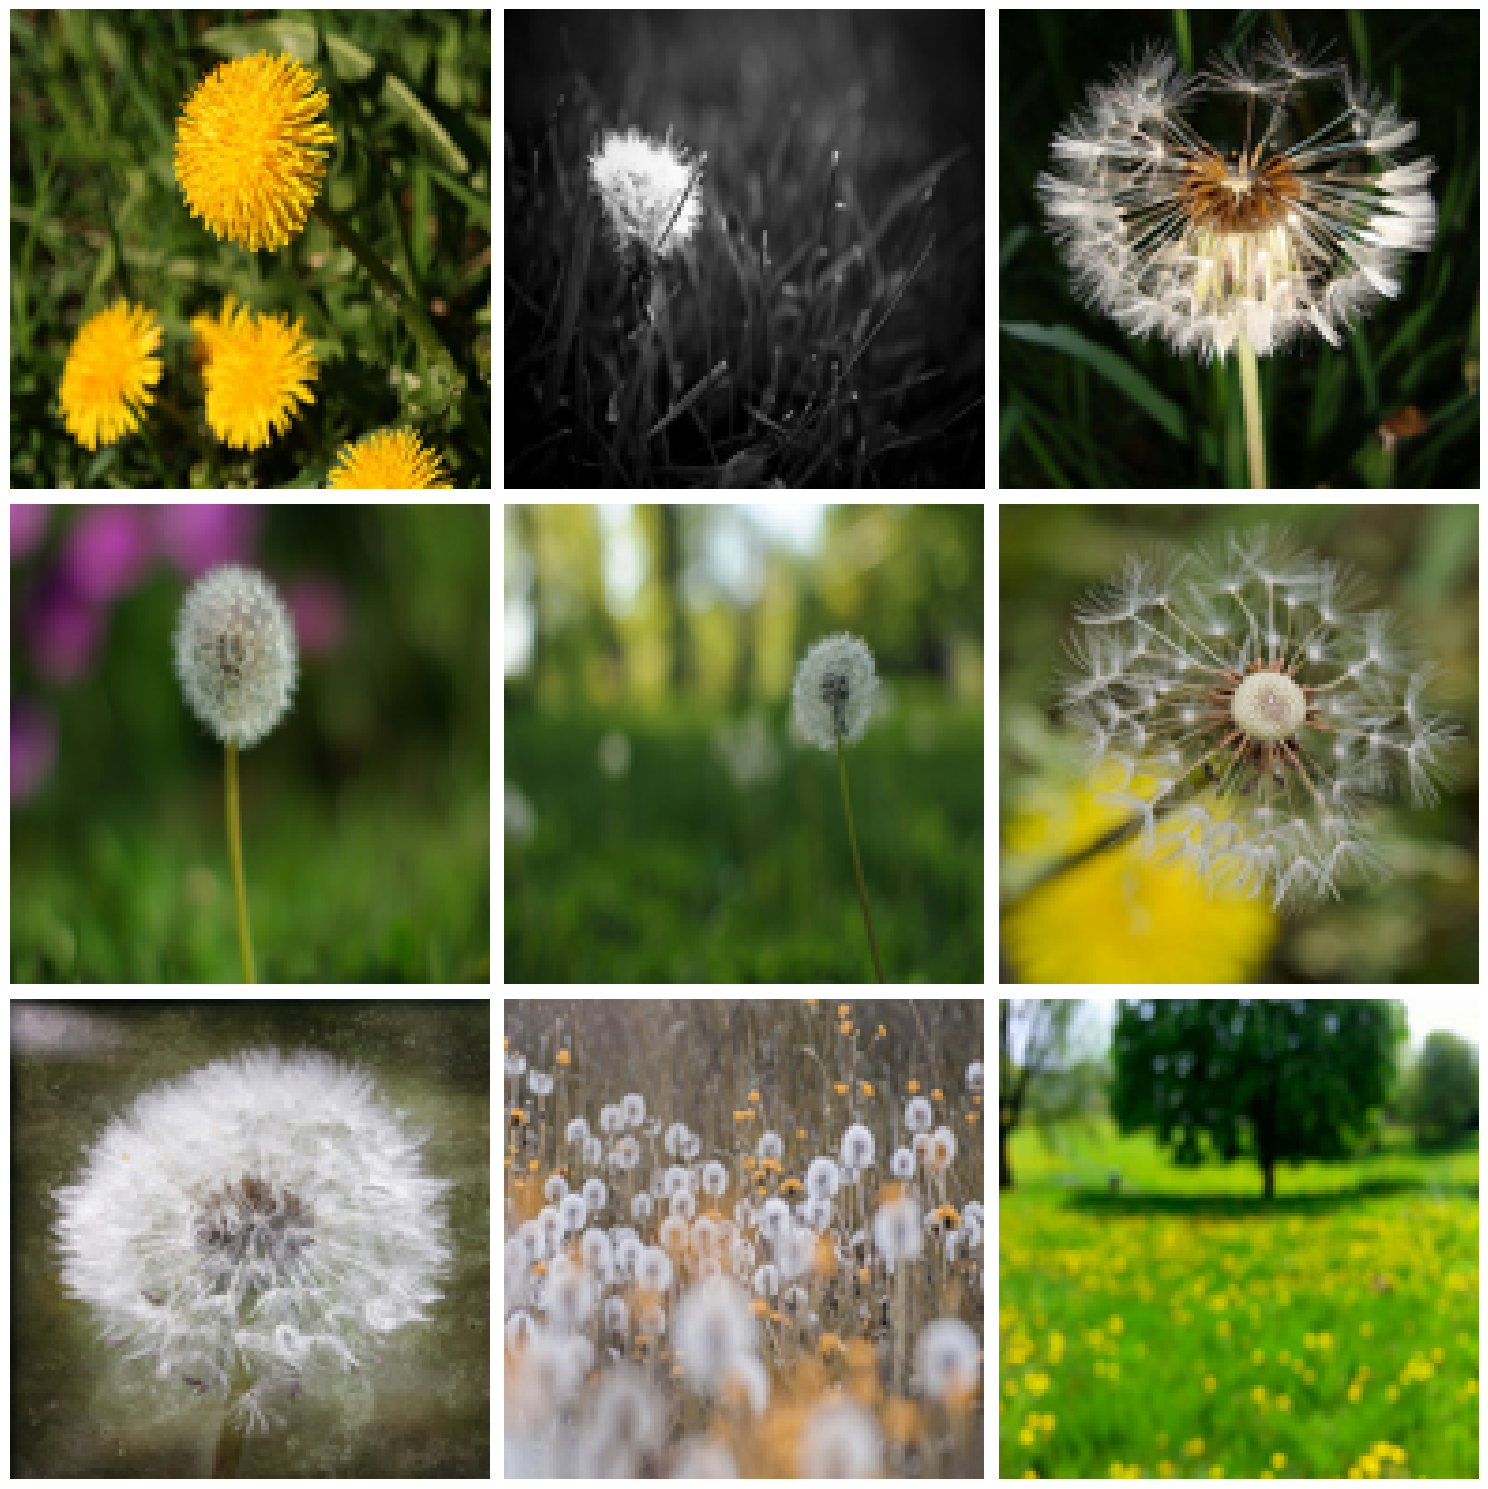

In [6]:
# X_train_split에서 이미 정규화된 이미지를 가져옴
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

# 3x3 그리드로 이미지를 시각화
for i in range(3):
    for j in range(3):
        img = X_train[i * 3 + j]  # X_train_split에서 이미지를 선택
        ax[i, j].imshow(img)  # 이미지를 시각화
        ax[i, j].axis('off')  # 축을 숨김

plt.tight_layout()
plt.show()

### 흑백이미지 확인

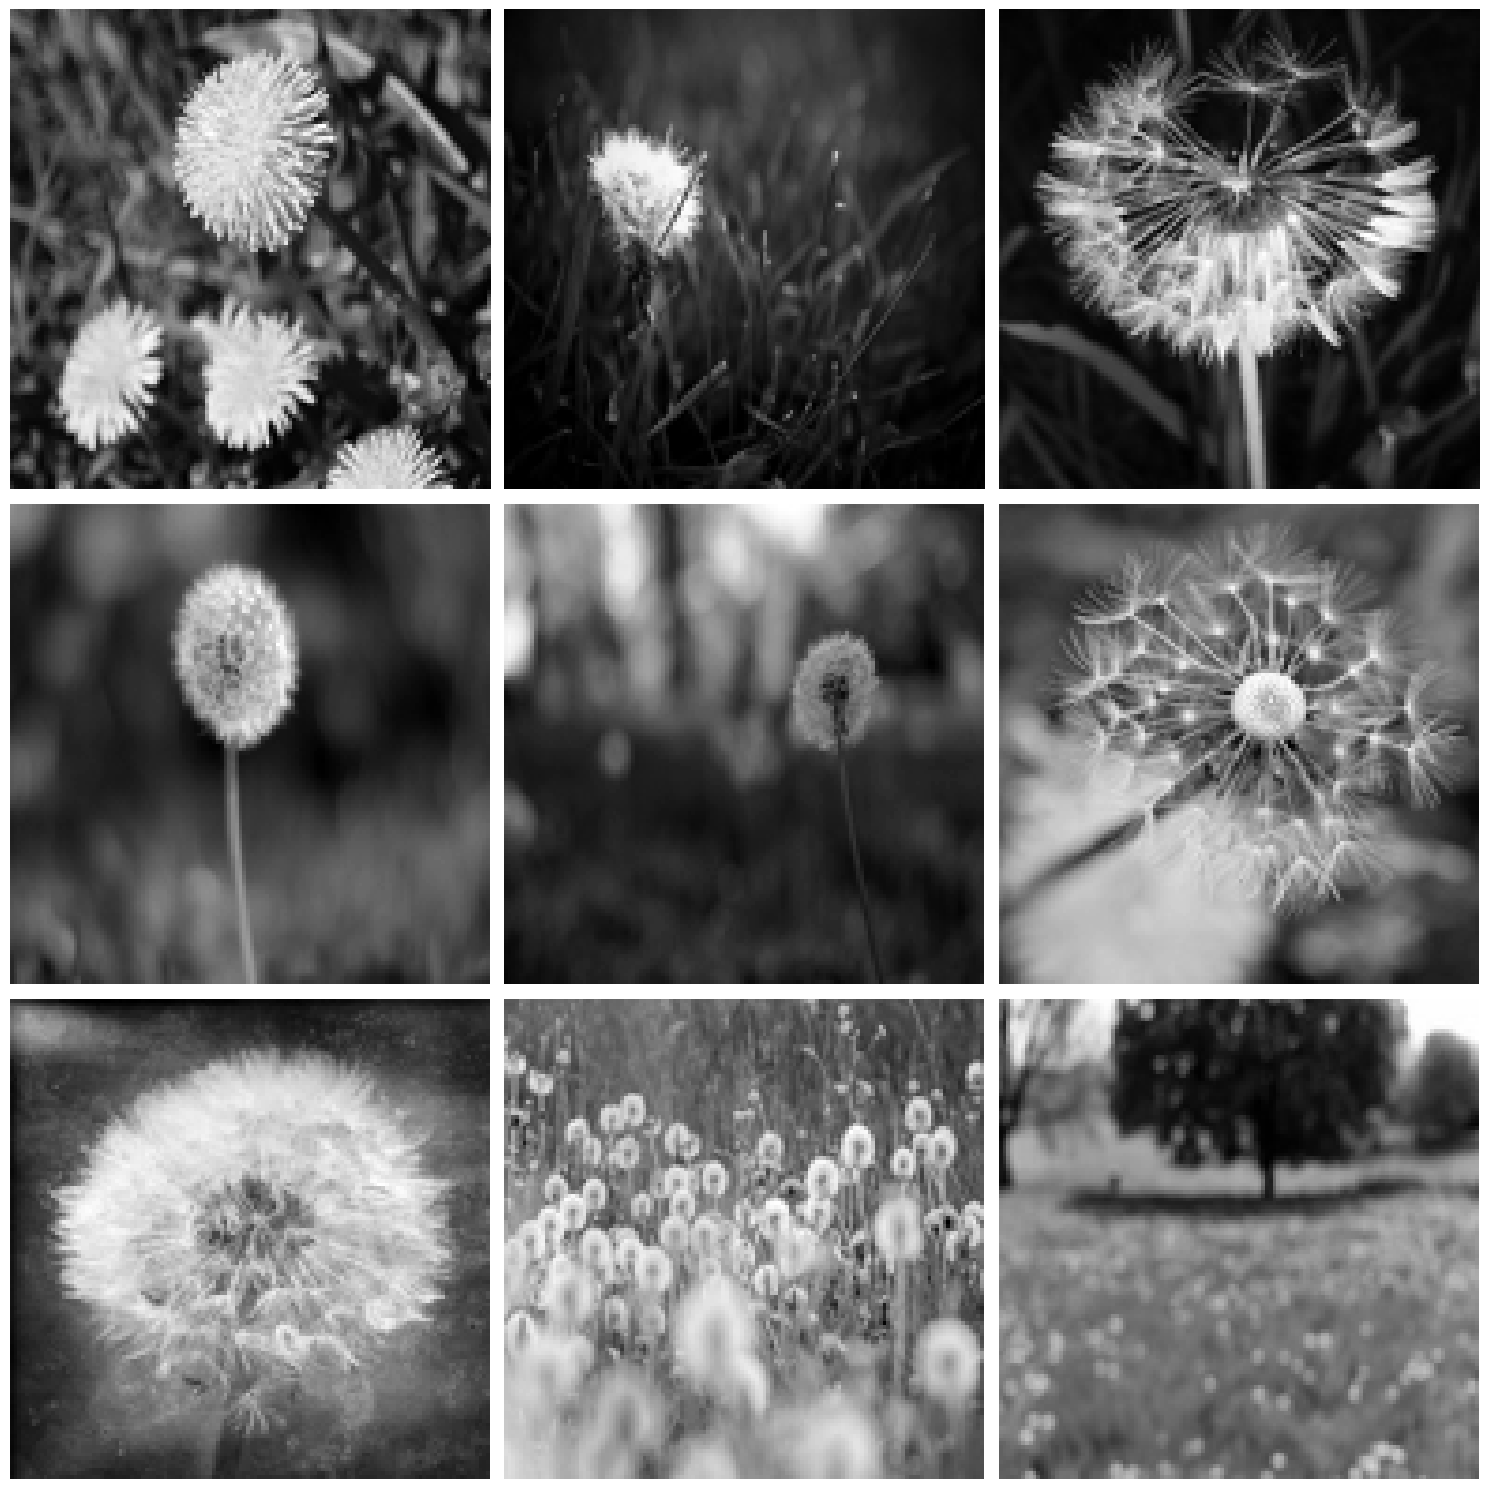

In [7]:
# X_train_split에서 이미 정규화된 이미지를 가져옴
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

# 3x3 그리드로 이미지를 시각화
for i in range(3):
    for j in range(3):
        img = X_train[i * 3 + j]  # X_train_split에서 이미지를 선택

        # 이미지를 흑백으로 변환 (0-255 범위로 변환 후 흑백화)
        img_gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)

        ax[i, j].imshow(img_gray, cmap='gray')  # 흑백 이미지 시각화
        ax[i, j].axis('off')  # 축을 숨김

plt.tight_layout()
plt.show()

* 이미지 분포 확인

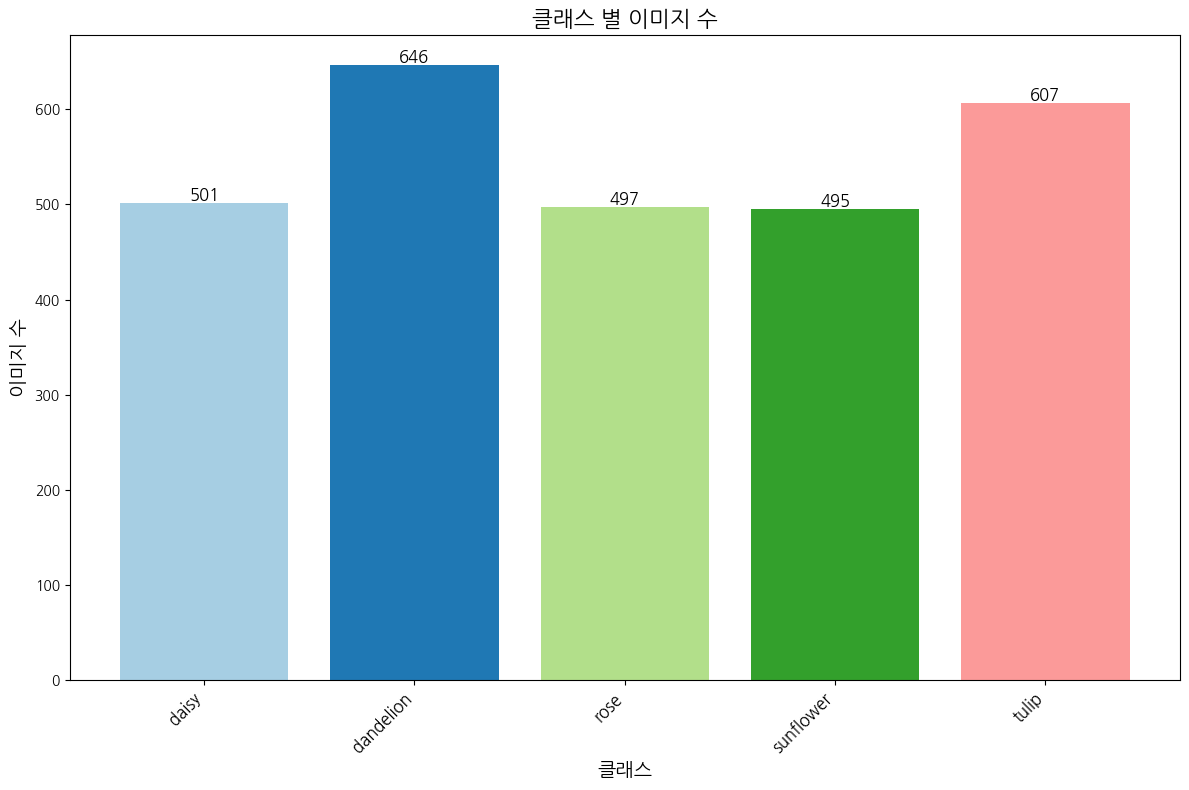

In [8]:
image_counts = {}

# 이미지 수 계산
for label in np.unique(y_train):  # y_train에서 고유한 클래스들에 대해 반복
    count = np.sum(y_train == label)  # 해당 클래스의 이미지 수 계산
    image_counts[label] = count

# 시각화
plt.figure(figsize=(12, 8))

# 클래스별 이미지 수 바 차트 생성
bars = plt.bar(image_counts.keys(), image_counts.values(), color=plt.cm.Paired(range(len(image_counts))))

# 제목과 라벨 설정
plt.xlabel('클래스', fontsize=14)
plt.ylabel('이미지 수', fontsize=14)
plt.title('클래스 별 이미지 수', fontsize=16)

# x축 레이블 회전
plt.xticks(rotation=45, ha='right', fontsize=12)

# 각 바 위에 이미지 수를 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=12)

# 레이아웃 정리
plt.tight_layout()

# 그래프 표시
plt.show()

### 데이터셋 분할

훈련 데이터를 학습용과 검증용으로 나눠 과적합 방지

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# 학습 데이터와 검증 데이터를 80%/20%로 분할
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)



# OneHotEncoder는 2D 배열을 요구하므로, 레이블을 2D 배열로 변환
y_train_split = y_train_split.reshape(-1, 1)
y_val_split = y_val_split.reshape(-1, 1)

# OneHotEncoder 사용하여 원-핫 인코딩 (sparse_output=False로 설정)
encoder = OneHotEncoder(sparse_output=False)  # sparse_output=False로 설정
y_train_split = encoder.fit_transform(y_train_split)
y_val_split = encoder.transform(y_val_split)
# 인코딩된 클래스 순서를 확인 (0부터 시작하는 클래스 번호)
print("클래스 순서:", encoder.categories_)

# 데이터 타입 확인
print(X_train_split.dtype)  # float32
print(y_train_split.dtype)  # int64 (원-핫 인코딩 후)

클래스 순서: [array(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], dtype='<U9')]
float64
float64


## 모델 구축 및 훈련

* MLP

In [10]:
from keras import Input, models, layers
# MLP 모델 구축
model_mlp = models.Sequential([
    Input(shape=(128, 128, 3)),  # 입력층 크기 변경 (128x128 크기로 처리)
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),     # 첫 번째 은닉층
    layers.Dense(512, activation='relu'),     # 두 번째 은닉층
    layers.Dense(512, activation='relu'),     # 세 번째 은닉층
    layers.Dense(5, activation='softmax')    # 출력층 (5개의 클래스)
])

# 모델 요약
model_mlp.summary()

# 모델 컴파일
model_mlp.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
with tf.device('/GPU:0'):  # GPU를 명시적으로 지정
    history_mlp = model_mlp.fit(X_train_split,
                         y_train_split, epochs=10,
                        validation_data=(X_val_split, y_val_split))

# 모델 평가
test_loss, test_acc = model_mlp.evaluate(X_val_split,y_val_split)
print(f"테스트 정확도: {test_acc * 100:.2f}%")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      50,332,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,122,693 (195.02 MB)

 Trainable params: 51,122,693 (195.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.2375 - loss: 16.6828 - val_accuracy: 0.3873 - val_loss: 1.4169
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4283 - loss: 1.3740 - val_accuracy: 0.4400 - val_loss: 1.3006
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4419 - loss: 1.3343 - val_accuracy: 0.4418 - val_loss: 1.2719
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4409 - loss: 1.2670 - val_accuracy: 0.4582 - val_loss: 1.2898
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5009 - loss: 1.2246 - val_accuracy: 0.3964 - val_loss: 1.6534
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5009 - loss: 1.2600 - val_accuracy: 0.4836 - val_loss: 1.3730
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5341 - loss: 1.1212 - val_accuracy: 0.4673 - val_loss: 1.3291
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5430 - loss: 1.1286 - val_accuracy: 0.4164 - val_l

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


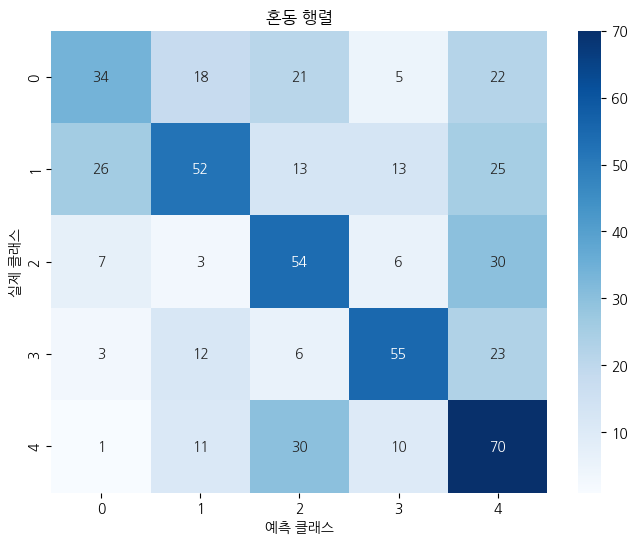

클래스 순서: [array(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], dtype='<U9')]


In [11]:
# 모델 예측
y_pred = model_mlp.predict(X_val_split)  # 예측 확률값

# 예측 결과에서 가장 높은 확률을 가지는 클래스를 선택
y_pred_classes = np.argmax(y_pred, axis=1)

# 실제 레이블도 원-핫 인코딩 되어 있으므로, argmax로 클래스 선택
y_val_classes = np.argmax(y_val_split, axis=1)

# 혼동 행렬 생성
cm = confusion_matrix(y_val_classes, y_pred_classes)

# 혼동 행렬 시각화 (히트맵으로 표현)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))
plt.xlabel('예측 클래스')
plt.ylabel('실제 클래스')
plt.title('혼동 행렬')
plt.show()
# 인코딩된 클래스 순서를 확인 (0부터 시작하는 클래스 번호)
print("클래스 순서:", encoder.categories_)


만족하지 못할만한 결과다. 해당 모델은 튤립에 관한 분류를 잘 해내고 있지 못하다.

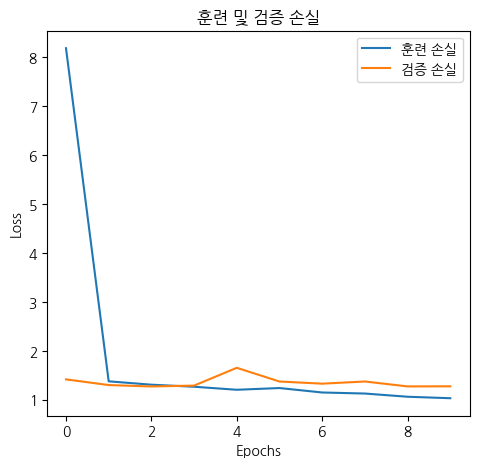

In [12]:
# 손실률과 정확도 시각화
plt.figure(figsize=(12, 5))

# 손실률
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='훈련 손실')
plt.plot(history_mlp.history['val_loss'], label='검증 손실')
plt.title('훈련 및 검증 손실')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


0에폭에서는 훈련손실과 검증손실이 크게 차이났지만 점차 비슷하게 흘러가는 모습을 볼 수 있다.

* CNN

In [13]:
# CNN 모델 정의
model_cnn = models.Sequential([
    # 첫 번째 Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    # 두 번째 Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 세 번째 Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected (Dense) Layer
    layers.Dense(64, activation='relu'),

    # 출력층 (10개의 클래스)
    layers.Dense(5, activation='softmax')
])

# 모델 요약
model_cnn.summary()

# 모델 컴파일
model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
with tf.device('/GPU:0'):  # GPU를 명시적으로 지정
    history_cnn = model_cnn.fit(X_train_split, y_train_split,
                        epochs=10,
                        validation_data=(X_val_split, y_val_split))
# 모델 평가
test_loss, test_acc = model_cnn.evaluate(X_val_split, y_val_split)
print(f"테스트 정확도: {test_acc * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,267,973 (12.47 MB)

 Trainable params: 3,267,973 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.2811 - loss: 1.6240 - val_accuracy: 0.4164 - val_loss: 1.3050
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5055 - loss: 1.2251 - val_accuracy: 0.5673 - val_loss: 1.0947
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5643 - loss: 1.0535 - val_accuracy: 0.5527 - val_loss: 1.0338
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6266 - loss: 0.9324 - val_accuracy: 0.5764 - val_loss: 1.0813
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7071 - loss: 0.7531 - val_accuracy: 0.6291 - val_loss: 0.9343
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7534 - loss: 0.6538 - val_accuracy: 0.6345 - val_loss: 0.9984
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8133 - loss: 0.4867 - val_accuracy: 0.6400 - val_loss: 1.0789
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8875 - loss: 0.3325 - val_accuracy: 0.6455 - val_loss

#### 손실률의 시각화 및 정확도, 혼동행렬

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


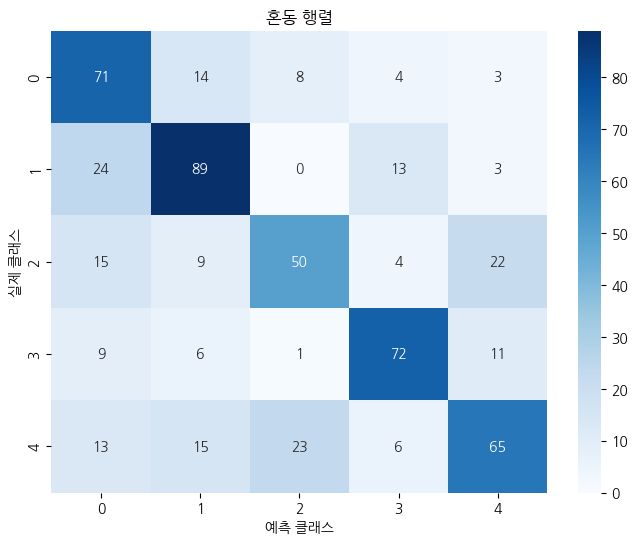

클래스 순서: [array(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], dtype='<U9')]


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#혼동 행렬 (Confusion Matrix)
y_pred = model_cnn.predict(X_val_split)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측된 클래스를 가져오기 위해 argmax 사용

cm = confusion_matrix(y_val_classes, y_pred_classes)

# 혼동 행렬 시각화 (히트맵으로 표현)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))
plt.xlabel('예측 클래스')
plt.ylabel('실제 클래스')
plt.title('혼동 행렬')
plt.show()
# 인코딩된 클래스 순서를 확인 (0부터 시작하는 클래스 번호)
print("클래스 순서:", encoder.categories_)



테스트 결과는 나아졌지만, 과대적합일 것으로 예상되어 검증이 필요한 상태다. 해당 모델은 데이지를 분류하는데 문제가 있어 보인다.

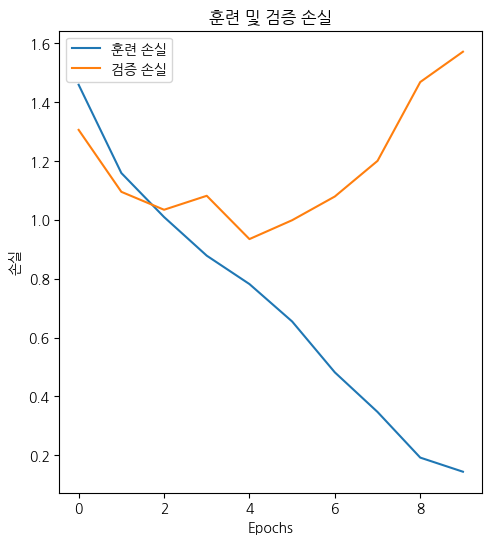

In [15]:
# 학습 손실 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='훈련 손실')
plt.plot(history_cnn.history['val_loss'], label='검증 손실')
plt.title('훈련 및 검증 손실')
plt.xlabel('Epochs')
plt.ylabel('손실')
plt.legend()

손실함수를 봤을 때 검증곡선과의 차이가 크다. 이에 따라 해당 그래프는 과대적합 되어있음을 알 수 있다

* 학습한 cnn모델의 결과를 예측한후 이 예측값을 토대로 다른 모델의 입력값으로 사용한다.

In [16]:
# CNN 모델을 훈련시킨 후 예측값 얻기
cnn_predictions = model_cnn.predict(X_train_split)
cnn_pred_labels = np.argmax(cnn_predictions, axis=1)  # 클래스 예측 (최대 확률인 인덱스)

# CNN 예측 결과 출력 (예: 클래스 레이블)
print("CNN 예측 레이블 (첫 5개):", cnn_pred_labels[:5])

# CNN 예측 결과를 다른 모델의 학습 데이터로 사용
X_train_cnn = cnn_pred_labels.reshape(-1, 1)  # 1D로 변환
y_train_cnn = y_train_split

# 훈련/테스트 데이터 분할
X_train_cnn_split, X_val_cnn_split, y_train_cnn_split, y_val_cnn_split = train_test_split(X_train_cnn, y_train_cnn, test_size=0.2, random_state=42)


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
CNN 예측 레이블 (첫 5개): [2 1 4 1 1]


In [17]:
from sklearn.metrics import confusion_matrix
# 혼동행렬 구하기 위한 함수
def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


class_names =['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

* CNN+KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# 1. KNN 모델
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_cnn_split, y_train_cnn_split)
knn_pred = knn.predict(X_val_cnn_split)
knn_acc = accuracy_score(y_val_cnn_split, knn_pred)
print(f"KNN 정확도: {knn_acc * 100:.2f}%")


KNN 정확도: 98.86%


과대적합으로 보인다.

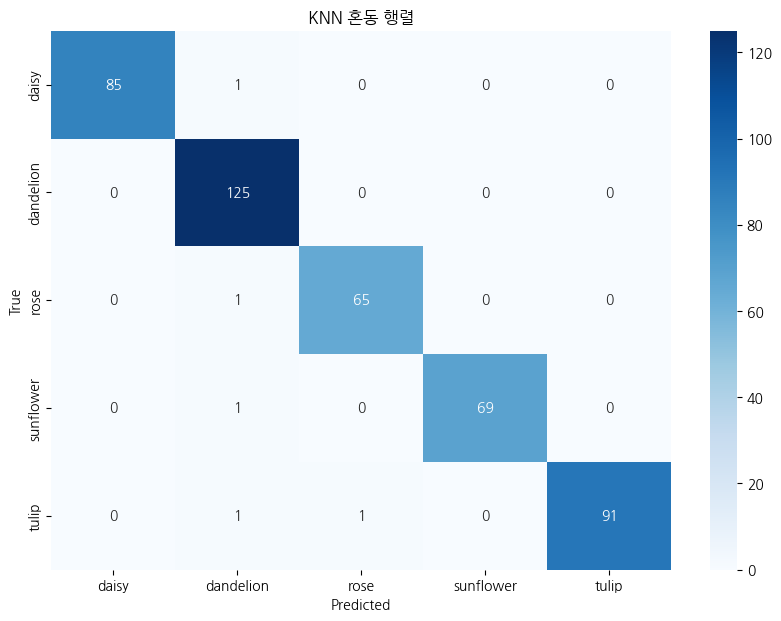

In [19]:
# 1. KNN 혼동 행렬
knn_cm = confusion_matrix(np.argmax(y_val_cnn_split, axis=1), np.argmax(knn_pred, axis=1))
plot_confusion_matrix(knn_cm, class_names, "KNN 혼동 행렬")


심하게 정확도가 높다. 해당 모델은 과대적합일 확률이 농후하다.

* CNN+SVM

In [20]:
from sklearn.svm import SVC

# 이미지 데이터를 2D로 변환 (각 이미지의 feature를 1D로 펼침)
X_train_cnn_split_SVM = X_train_cnn_split.reshape(X_train_cnn_split.shape[0], -1)  # (n_samples, height * width * channels)
X_val_cnn_split_SVM = X_val_cnn_split.reshape(X_val_cnn_split.shape[0], -1)  # 검증 데이터도 동일하게 변환

# y_train_cnn_split와 y_val_cnn_split이 원핫 인코딩된 상태라면 1D로 변환
y_train_cnn_split_SVM = np.argmax(y_train_cnn_split, axis=1)  # 원핫 인코딩을 1D로 변환
y_val_cnn_split_SVM = np.argmax(y_val_cnn_split, axis=1)  # 검증 데이터도 동일하게 변환

svm = SVC()
svm.fit(X_train_cnn_split, y_train_cnn_split_SVM)
svm_pred = svm.predict(X_val_cnn_split_SVM)
svm_acc = accuracy_score(y_val_cnn_split_SVM, svm_pred)
print(f"SVM 정확도: {svm_acc * 100:.2f}%")

SVM 정확도: 98.86%


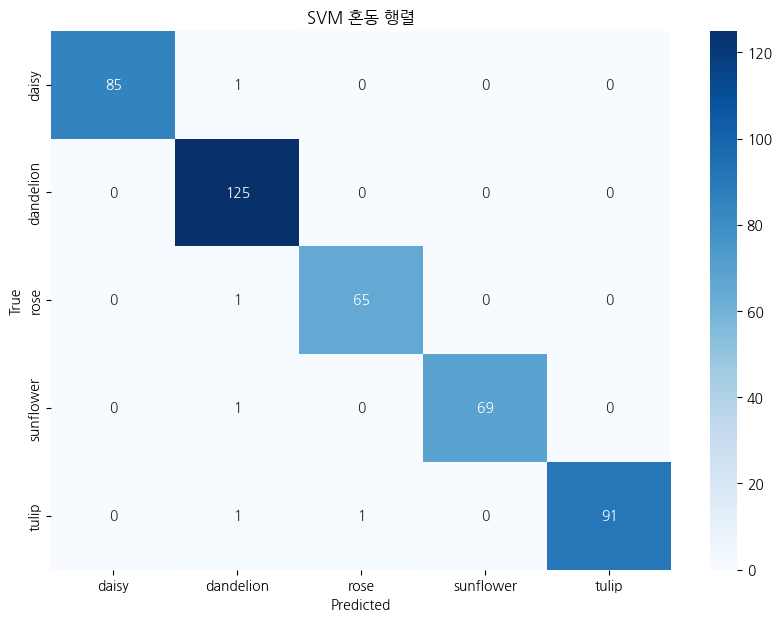

In [21]:
svm_cm = confusion_matrix(y_val_cnn_split_SVM, svm_pred)
plot_confusion_matrix(svm_cm, class_names, "SVM 혼동 행렬")

해당 모델은 과대적합된 모델일 가능성이 농후하다

* CNN+DT

In [22]:
from sklearn.tree import DecisionTreeClassifier

# 3. Decision Tree 모델
dt = DecisionTreeClassifier()
dt.fit(X_train_cnn_split, y_train_cnn_split)
dt_pred = dt.predict(X_val_cnn_split)
dt_acc = accuracy_score(y_val_cnn_split, dt_pred)
print(f"DecisionTree 정확도: {dt_acc * 100:.2f}%")

DecisionTree 정확도: 98.86%


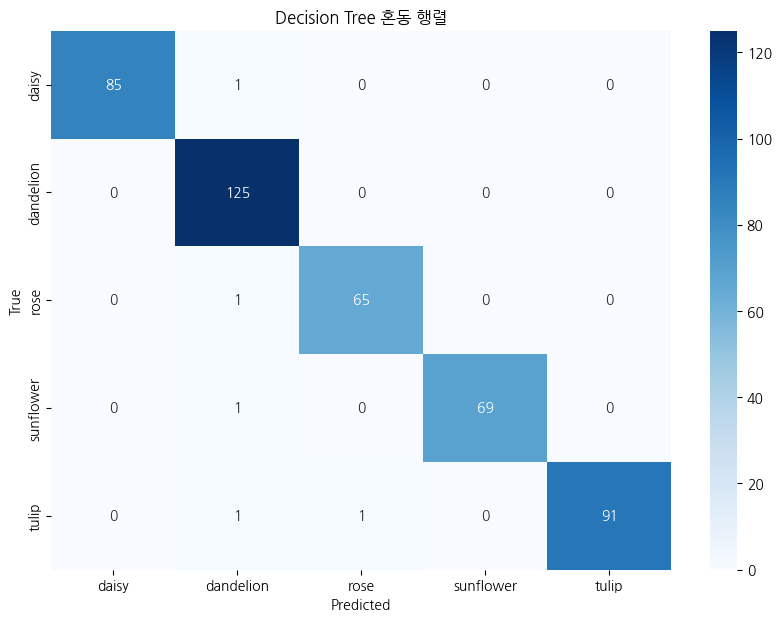

In [23]:
dt_cm = confusion_matrix(np.argmax(y_val_cnn_split, axis=1), np.argmax(dt_pred,axis=1))
plot_confusion_matrix(dt_cm, class_names, "Decision Tree 혼동 행렬")

위와 같이 과대적합 된 모델이다.

* CNN + MLP

In [24]:
model_CNN_MLP = keras.models.Sequential([
    # 첫 번째 Conv2D 레이어
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2), strides=2),

    # 두 번째 Conv2D 레이어
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),

    # 세 번째 Conv2D 레이어
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),

    # 평탄화 레이어
    layers.Flatten(),

    # MLP Dense 레이어
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')  # 10개의 클래스 출력
])
# 모델 요약
model_CNN_MLP.summary()

# 모델 컴파일
model_CNN_MLP.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history = model_CNN_MLP.fit(X_train_split, y_train_split,
                            epochs=10,
                            validation_data=(X_val_split, y_val_split))
# 모델 평가
test_loss, test_acc = model_CNN_MLP.evaluate(X_val_split, y_val_split)
print(f"테스트 정확도: {test_acc * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,296,261 (16.39 MB)

 Trainable params: 4,296,261 (16.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.3162 - loss: 1.4882 - val_accuracy: 0.5182 - val_loss: 1.2220
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5827 - loss: 1.0689 - val_accuracy: 0.6200 - val_loss: 0.9913
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6511 - loss: 0.8669 - val_accuracy: 0.6145 - val_loss: 0.9736
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7445 - loss: 0.6879 - val_accuracy: 0.6527 - val_loss: 0.9979
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8066 - loss: 0.5172 - val_accuracy: 0.6364 - val_loss: 1.0224
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8894 - loss: 0.3247 - val_accuracy: 0.6291 - val_loss: 1.1812
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9192 - loss: 0.2413 - val_accuracy: 0.6400 - val_loss: 1.4103
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9627 - loss: 0.1224 - val_accuracy: 0.6273 - val_los

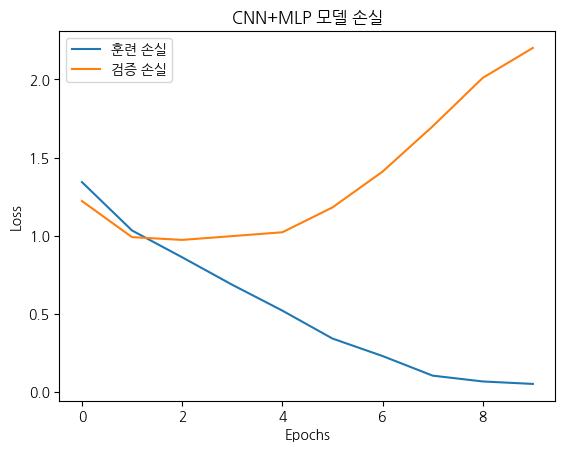

In [25]:
# 손실 그래프
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN+MLP 모델 손실')
plt.legend()
plt.show()

해당 모델 또한 검증곡선과 훈련곡선의 경향이 반대로 흘러간다. 과대적합일 확률이 높다.

* 모델의 정확도를 올리기 위해서 드랍아웃 추가, 데이터 증강(DataAugmentation), 레이어 추가 등 여러 방법을 모색해본다.

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CNN+MLP 모델 개선
model_CNN_MLP_improved = Sequential([
    # 첫 번째 Conv2D 레이어
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2), strides=2),

    # 두 번째 Conv2D 레이어
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),

    # 세 번째 Conv2D 레이어
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),  # 배치 정규화
    MaxPooling2D((2, 2), strides=2),

    # Dropout 추가
    Dropout(0.3),  # 30%의 확률로 뉴런을 끔

    # 평탄화 레이어
    Flatten(),

    # Dense 레이어
    Dense(512, activation='relu'),  # 히든 레이어의 노드 수를 증가시킴
    Dropout(0.2),
    Dense(512, activation='relu'),  # 히든 레이어추가
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # 10개의 클래스 출력
])

# 모델 요약
model_CNN_MLP_improved.summary()

# 모델 컴파일
model_CNN_MLP_improved.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 데이터 증강을 위한 학습 데이터 준비
datagen.fit(X_train_split)

# 모델 훈련 (Data Augmentation 적용)
history_improved = model_CNN_MLP_improved.fit(datagen.flow(X_train_split, y_train_split, batch_size=32),
                                              epochs=10,
                                              validation_data=(X_val_split, y_val_split))

# 모델 평가
test_loss, test_acc = model_CNN_MLP_improved.evaluate(X_val_split, y_val_split)
print(f"테스트 정확도: {test_acc * 100:.2f}%")


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,167,301 (65.49 MB)

 Trainable params: 17,167,045 (65.49 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.3327 - loss: 2.0219 - val_accuracy: 0.2945 - val_loss: 1.5510
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.4768 - loss: 1.2622 - val_accuracy: 0.3618 - val_loss: 1.4732
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.5457 - loss: 1.1415 - val_accuracy: 0.4200 - val_loss: 1.4082
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.5993 - loss: 1.0138 - val_accuracy: 0.4036 - val_loss: 1.3777
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.6468 - loss: 0.9580 - val_accuracy: 0.5036 - val_loss: 1.2644
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.6378 - loss: 0.9096 - val_accuracy: 0.5982 - val_loss: 1.1246
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.6382 - loss: 0.9240 - val_accuracy: 0.6055 - val_loss: 1.0507
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.6687 - loss: 0.8259 - val_accuracy: 0.6927 - val

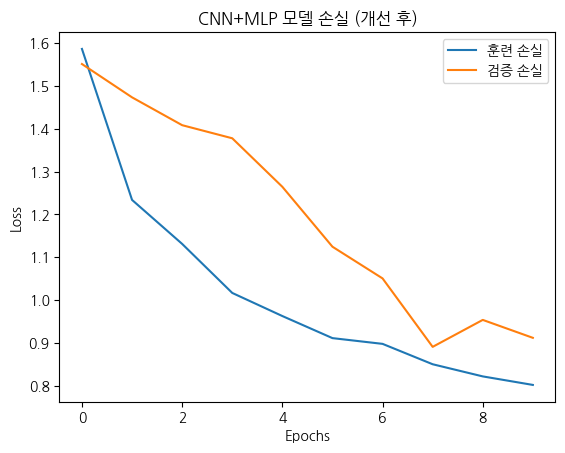

In [27]:
# 손실 그래프
plt.plot(history_improved.history['loss'], label='훈련 손실')
plt.plot(history_improved.history['val_loss'], label='검증 손실')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN+MLP 모델 손실 (개선 후)')
plt.legend()
plt.show()

방금과는 다르게 훈련과 검증모델의 경향이 비슷하게 흘러간다. 해당 개선된 모델은 이전의 모델보다는 적합하게 설계되었다고 볼 수 있다.

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


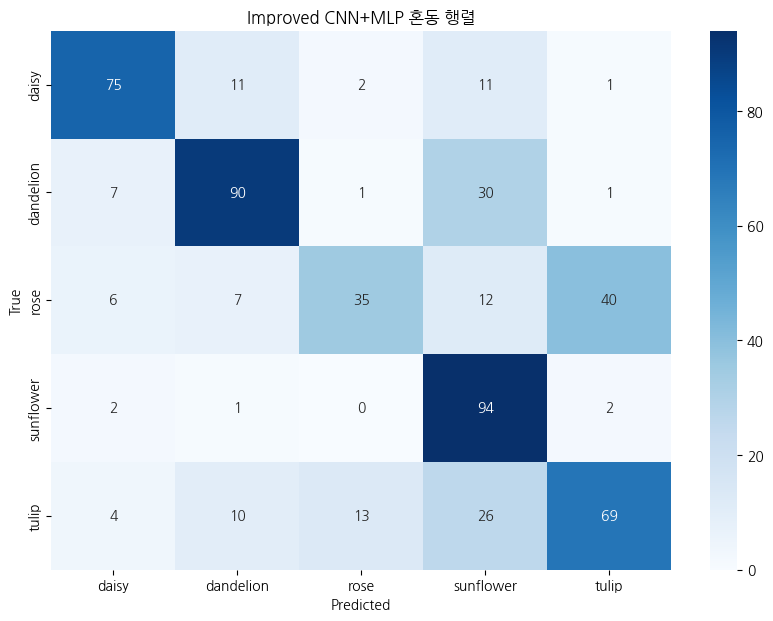

In [28]:
# 예측
y_pred_improved = model_CNN_MLP_improved.predict(X_val_split)
y_pred_labels = np.argmax(y_pred_improved, axis=1)  # 예측된 클래스 레이블

# 혼동 행렬 생성
cm_improved = confusion_matrix(np.argmax(y_val_split,axis=1), y_pred_labels)

plot_confusion_matrix(cm_improved, class_names, "Improved CNN+MLP 혼동 행렬")

테스트 정확도가 늘어난것을 볼 수 있다. 하지만 장미와 튤립같이 색깔이 비슷한 경우 해당 데이터에서 오차가 크게 보이는것을 알 수 있다.

* 모델의 적용   
  데이터에서 input값만 랜덤으로 10개를 얻어내 얼마나 정확한지 적용해본다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
랜덤 샘플 20개의 예측 정확도: 70.00%


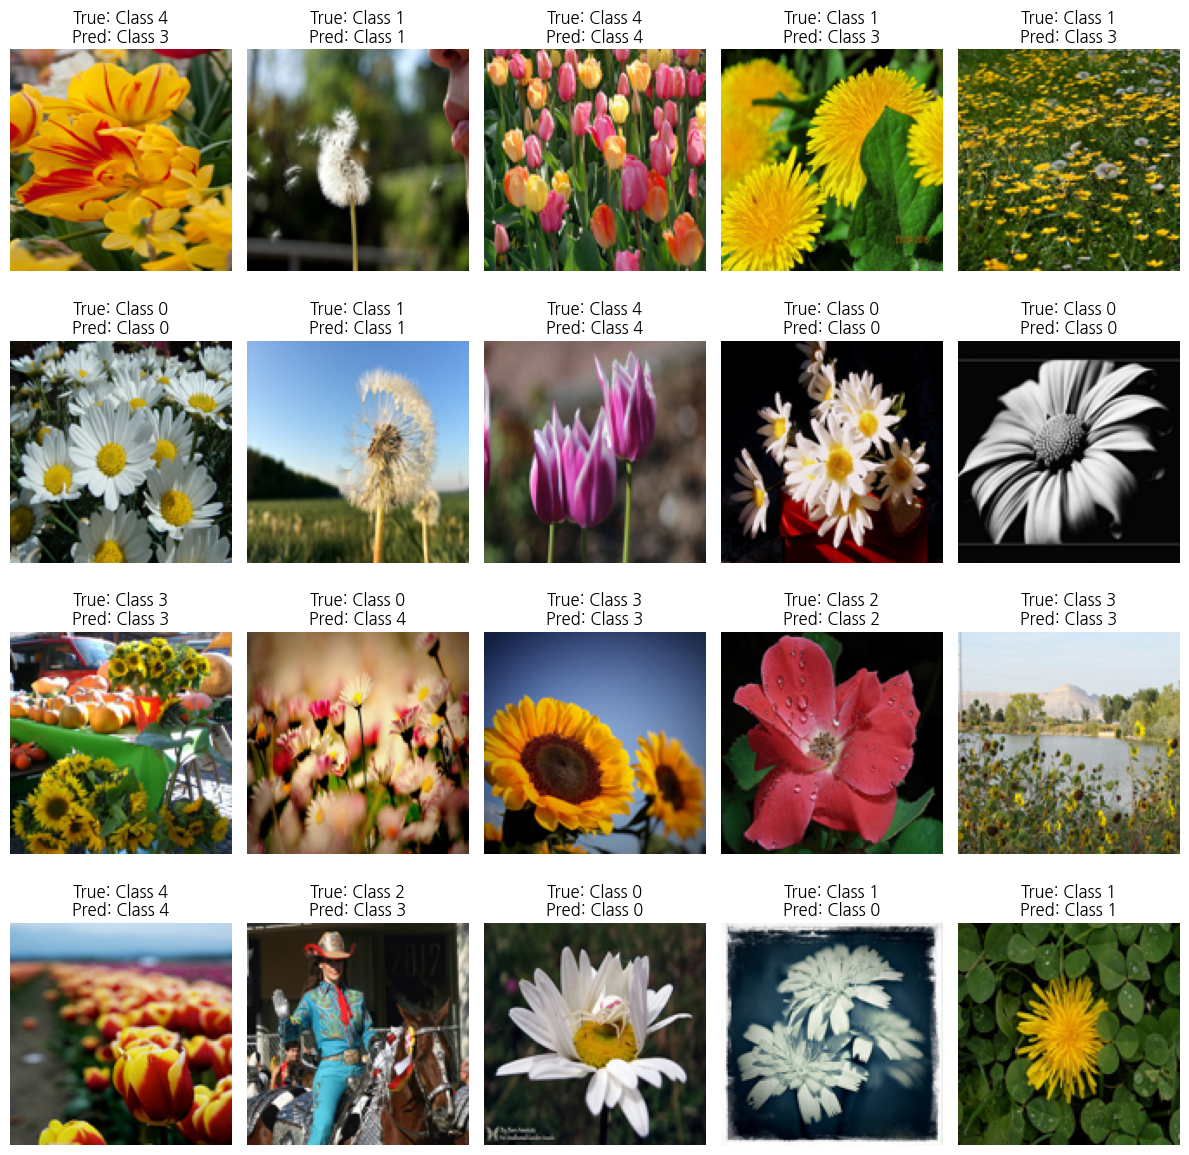

In [33]:
# 1. 훈련 데이터에서 12개의 샘플을 랜덤으로 선택
random_indices = np.random.choice(len(X_train_split), size=20, replace=False)
X_random = X_train_split[random_indices]
y_random = y_train_split[random_indices]

# 2. 모델 예측
y_pred = model_CNN_MLP_improved.predict(X_random)

# 3. 예측 결과와 실제 값을 비교하여 정확도 계산
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_random, axis=1)  # 원-핫 인코딩이므로 argmax를 사용하여 실제 클래스 추출

# 정확도 계산
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"랜덤 샘플 20개의 예측 정확도: {accuracy * 100:.2f}%")

# 4. 이미지와 예측 결과 출력
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']  # 예시 클래스 이름. 실제 클래스에 맞게 수정

plt.figure(figsize=(12, 12))

for i in range(20):
    plt.subplot(4, 5, i+1)  # 4x5 그리드로 20개의 이미지를 출력
    plt.imshow(X_random[i])  # 이미지 출력
    plt.title(f"True: {class_names[y_true_classes[i]]}\nPred: {class_names[y_pred_classes[i]]}")  # 실제 클래스와 예측 클래스 출력
    plt.axis('off')  # 축 숨기기

plt.tight_layout()
plt.show()

20개를 랜덤으로 뽑아 시험한 결과가 양호하다. 해당 모델은 적절하다고 볼 수 있다. 해당 데이터에서 노이즈로 볼 수 있는 데이터 1개를 제외하면 73퍼로 양호한 성능을 보인다.

## 결론 및 고찰

해당 데이터셋은 꽃을 분류하기 위한 데이터셋으로 랜덤으로 샘플링하다가 위의 사진처럼 꽃이 아닌 노이즈급의 데이터도 존재함을 알아냈다. 해당 랜덤에러들을 전부 제거하면 성능이 더 나아질 수 있음에 아쉬웠다.      해당 실습을 하면서는 GPU관련 이슈가 없어 cuda확인 관련 코드는 제외했다. 모델에 대한 변경을 해보고, 그래프에 대한 해석을 해보면서, 정확도 뿐 아니라 과대적합된 모델을 걸러내는 것도 가능하다는 것을 알 수 있었다.